
# Geospatial Overlay Analysis — Self‑Contained Tutorial

This notebook demonstrates common **geospatial overlay** patterns with **synthetic data**, so you can run it without downloading anything:

1. Vector ↔ Vector: clip, intersection, spatial join  
2. Dissolve + area statistics  
3. Raster ↔ Vector: zonal mean (simple implementation)

> Requires: `geopandas`, `shapely`, `pyproj`, `matplotlib`, `rasterio`, `numpy`  
> Optional: `rasterstats` (not required here)


In [ ]:

# If running in a fresh environment, uncomment the next line:
# %pip install geopandas shapely pyproj rasterio matplotlib numpy
# We will use IL State Plate Map projection for this exercise
# Everything is in Illinois State Plane East (EPSG:3435, feet) so areas and distances make sense (planar CRS).
# Switch to a meters CRS (e.g., EPSG:26971) if you prefer SI units.

We will Create
- AOI: A 6,000×4,000 ft rectangle—our sandbox.

- Fields: A 3×2 grid of rectangular “plots” (polygons) with field_ids.

- Patches: Three translated rectangles representing “experimental plots,” each with a specific attribute.

- Sensor hits: 20 random points (think soil samples). We also make 250 ft buffers around them to mimic influence zones.

In [1]:

import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
from shapely.affinity import translate
import matplotlib.pyplot as plt

# We'll use Illinois State Plane East (feet) for this demo.
CRS_IL_E = "EPSG:3435"


## 1) Setup & Synthetic Layers

In [2]:

# --- Make an AOI rectangle and a grid of 3x2 "fields"
aoi = box(0, 0, 6000, 4000)  # 6k x 4k ft
fields = []
fid = 1
for i in range(3):       # columns
    for j in range(2):   # rows
        poly = box(500 + i*1800, 500 + j*1600, 2000 + i*1800, 1800 + j*1600)
        fields.append({"field_id": fid, "geometry": poly})
        fid += 1
gdf_fields = gpd.GeoDataFrame(fields, crs=CRS_IL_E)

# --- Make some "patches" (e.g., disease patches) as translated polygons
base_patch = Polygon([(0,0),(800,0),(800,600),(0,600)])
patch_polys = [
    translate(base_patch, xoff=1400, yoff=1200),
    translate(base_patch, xoff=2600, yoff=900),
    translate(base_patch, xoff=3400, yoff=2500),
]
gdf_patches = gpd.GeoDataFrame(
    {"patch_id":[101,102,103], "severity":[0.2,0.6,0.8], "geometry":patch_polys},
    crs=CRS_IL_E
)

# --- Make some “sensor hits” (points) and buffer them (e.g., VOC detection zones)
rng = np.random.default_rng(42)
pts = []
for k in range(20):
    x = rng.uniform(800, 5200)
    y = rng.uniform(700, 3300)
    pts.append(Point(x, y))
gdf_hits = gpd.GeoDataFrame({"hit_id": range(1,21)}, geometry=pts, crs=CRS_IL_E)
gdf_hitbuf = gdf_hits.copy()
gdf_hitbuf["geometry"] = gdf_hitbuf.buffer(250)  # 250 ft buffer

# Wrap AOI into a GeoDataFrame for convenience
gdf_aoi = gpd.GeoDataFrame({"name":["AOI"]}, geometry=[aoi], crs=CRS_IL_E)


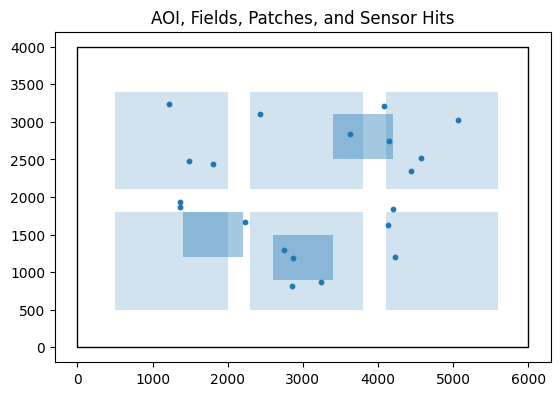

In [3]:
## Visualization
ax = gdf_aoi.plot(edgecolor=None, facecolor="none")
gdf_fields.plot(ax=ax, alpha=0.2)
gdf_patches.plot(ax=ax, alpha=0.4)
gdf_hits.plot(ax=ax, markersize=10)
plt.title("AOI, Fields, Patches, and Hits")
plt.show()


## 2) Vector Overlay Examples

In [14]:

# A) Clip patches to the AOI (or to the union of fields)
# Use when you need to mask features to a study area or a set of polygons.
patches_in_aoi = gpd.overlay(gdf_patches, gdf_aoi, how="intersection")

fields_union = gdf_fields.unary_union
patches_in_fields = gpd.clip(gdf_patches, fields_union)

print("Patches intersecting AOI:", len(patches_in_aoi))
print("Patches intersecting any field:", len(patches_in_fields))


Patches intersecting AOI: 3
Patches intersecting any field: 3


/tmp/ipython-input-1552095000.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  fields_union = gdf_fields.unary_union


In [5]:

# B) Which patches overlap which fields? (intersection)
# Use when you need per-pair overlaps and their areas.
patch_field_ix = gpd.overlay(gdf_patches, gdf_fields, how="intersection")
patch_field_ix["overlap_ft2"] = patch_field_ix.area
patch_field_ix_sorted = patch_field_ix[["patch_id","field_id","overlap_ft2"]].sort_values("overlap_ft2", ascending=False)
patch_field_ix_sorted.head()


,patch_id,field_id,overlap_ft2
1,102,3,480000.0
0,101,1,360000.0
2,103,4,240000.0
3,103,6,60000.0


In [6]:

# C) Spatial join: count sensor hits per field & per patch
# Use when point events need to be summarized by regions (counts, densities, etc.).

# Points-in-polygons count per field
hits_in_fields = gpd.sjoin(gdf_hits, gdf_fields, how="left", predicate="within")
hits_per_field = hits_in_fields.groupby("field_id", dropna=False).size().reset_index(name="n_hits")

# Points-in-polygons count per patch
hits_in_patches = gpd.sjoin(gdf_hits, gdf_patches, how="left", predicate="within")
hits_per_patch = hits_in_patches.groupby("patch_id", dropna=False).size().reset_index(name="n_hits")

hits_per_field, hits_per_patch


(   field_id  n_hits
 0       2.0       3
 1       3.0       4
 2       4.0       2
 3       5.0       2
 4       6.0       4
 5       NaN       5,
    patch_id  n_hits
 0     102.0       2
 1     103.0       2
 2       NaN      16)

In [7]:

# D) Dissolve fields by a simple block label and sum area
# Use when you need regional summaries: boundaries merged, statistics rolled up.
# acres = area / 43560

gdf_fields["block"] = np.where(gdf_fields["field_id"].isin([1,2,3]), "A", "B")
fields_by_block = gdf_fields.dissolve(by="block", as_index=False, aggfunc="sum")
fields_by_block["acres"] = fields_by_block.area / 43560.0
fields_by_block[["block","acres"]]


,block,acres
0,A,134.297521
1,B,134.297521


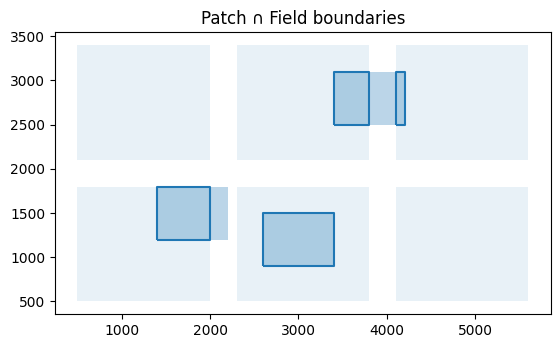

In [8]:
# Visualize
ax = gdf_fields.plot(alpha=0.1)
gdf_patches.plot(ax=ax, alpha=0.3)
patch_field_ix.boundary.plot(ax=ax)
plt.title("Patch ∩ Field boundaries")
plt.show()


## 3) Raster ↔ Vector Overlay (Zonal Mean)
We synthesize a “thermal” raster over the AOI:

  - Grid: 50 ft pixels using a transform from AOI bounds.

  - Values: A smooth ramp plus a Gaussian “hotspot.”

Then for each patch:

1. Rasterize the polygon to a boolean mask (rasterio.features.rasterize), aligned to the raster grid.

2. Use the mask to index the raster band and compute mean_temp.

**Why do it this way?** It’s the core of zonal stats without extra dependencies. In production, rasterstats.zonal_stats is convenient, but rasterizing yourself is flexible and fast.

In [10]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 59.2 MB/s eta 0:00:00


In [11]:

import rasterio
from rasterio.transform import from_origin

# Make a simple raster that varies smoothly with x,y
px = 50.0  # pixel size in feet
width  = int(np.ceil((aoi.bounds[2] - aoi.bounds[0]) / px))
height = int(np.ceil((aoi.bounds[3] - aoi.bounds[1]) / px))
transform = from_origin(aoi.bounds[0], aoi.bounds[3], px, px)

# Create synthetic "temperature" surface
yy, xx = np.mgrid[0:height, 0:width]
X = aoi.bounds[0] + xx * px
Y = aoi.bounds[3] - yy * px
temp = 70 + 0.004*X + 0.006*Y + 10*np.exp(-((X-3200)**2 + (Y-2100)**2)/(2*(800**2)))

raster_path = "thermal_demo.tif"
with rasterio.open(
    raster_path, "w",
    driver="GTiff",
    height=height, width=width,
    count=1, dtype=temp.dtype,
    crs=CRS_IL_E, transform=transform,
) as dst:
    dst.write(temp, 1)

raster_path


'thermal_demo.tif'

In [12]:

from rasterio.features import rasterize

def polygon_to_mask(polygon, transform, out_shape):
    """Rasterize a single polygon into a boolean mask in raster space."""
    return rasterize(
        [(polygon, 1)],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        all_touched=False,
        dtype="uint8"
    ).astype(bool)

means = []
with rasterio.open(raster_path) as src:
    band = src.read(1)
    for _, row in gdf_patches.iterrows():
        mask = polygon_to_mask(row.geometry, src.transform, (src.height, src.width))
        vals = band[mask]
        means.append({"patch_id": row.patch_id, "mean_temp": float(np.nanmean(vals))})

zonal_means = gpd.GeoDataFrame(means).merge(gdf_patches[["patch_id","severity","geometry"]], on="patch_id")
zonal_means[["patch_id","severity","mean_temp"]]


,patch_id,severity,mean_temp
0,101,0.2,87.949142
1,102,0.6,94.360841
2,103,0.8,107.048356


Quick maps show how layers relate (fields, patches, hits, and intersection boundaries).

Tabular outputs:

  - Overlap areas per (patch, field)

  - Counts of hits per field / per patch

  - Acres per dissolved block

  - Zonal mean temperature per patch

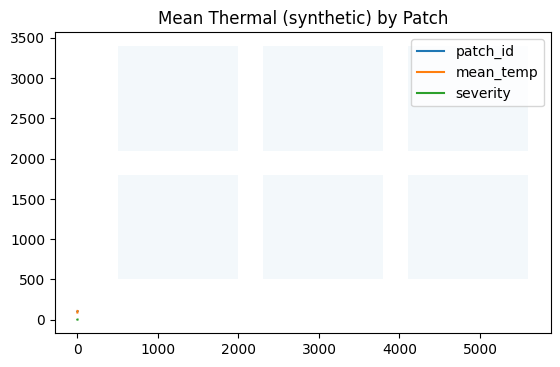

In [13]:

ax = gdf_fields.plot(alpha=0.05)
zonal_means.plot(ax=ax, column="mean_temp", legend=True)
plt.title("Mean Thermal (synthetic) by Patch")
plt.show()



### What you did
- **Clip / Intersection:** `gpd.clip` and `gpd.overlay(..., how="intersection")`
- **Spatial join:** `gpd.sjoin(points, polygons, predicate="within")`
- **Dissolve:** `gdf.dissolve(by="key")` to summarize geometry + attributes
- **Zonal stats:** Rasterize polygons to masks, calculate statistics on raster bands

### Variations
- Replace the synthetic raster (`thermal_demo.tif`) with a real TIFF.  
- Reproject to meters if needed, e.g., `EPSG:26971` for Illinois East (meters).  
- Add time and group-by cycles before spatial joins to make per‑cycle summaries.


**5) How to swap in your data**

- Replace synthetic layers with file reads:

  - `gpd.read_file("fields.geojson").to_crs("EPSG:3435")`

  - `rasterio.open("thermal.tif")` (use its CRS; reproject vectors to match)

- Change CRS to meters:

  - `gdf = gdf.to_crs("EPSG:26971")`

  - Update area conversions (no 43560 factor in meters; use /10_000 for hectares)

- Change stats: compute median, std, percentiles on the masked raster values.

In [17]:
rasterio.open("thermal_demo.tif")

<open DatasetReader name='thermal_demo.tif' mode='r'>

CRS: EPSG:3435
Bounds: BoundingBox(left=0.0, bottom=0.0, right=6000.0, top=4000.0)


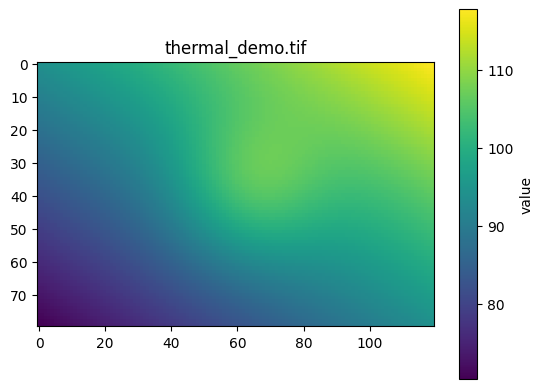

In [18]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Open
with rasterio.open("thermal_demo.tif") as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    arr = src.read(1)

# Quick look
plt.imshow(arr)
plt.title("thermal_demo.tif")
plt.colorbar(label="value")
plt.show()


You can open this `.tif` file in QGIS (GUI)

- Open QGIS → drag thermal_demo.tif into the Layers panel (or Layer → Add Layer → Add Raster Layer).

- Check the layer’s CRS (should be EPSG:3435 in this demo).

- Style → “Singleband gray” or “Singleband pseudocolor” for nicer display.

In [23]:
!apt-get install gdal-bin libgdal-dev
!pip install gdal

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.8.4+dfsg-1~jammy0).
libgdal-dev is already the newest version (3.8.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [24]:
!gdalinfo --version

GDAL 3.8.4, released 2024/02/08


In [25]:
# Inspect metadata
!gdalinfo thermal_demo.tif




Driver: GTiff/GeoTIFF
Files: thermal_demo.tif
Size is 120, 80
Coordinate System is:
PROJCRS["NAD83 / Illinois East (ftUS)",
    BASEGEOGCRS["NAD83",
        DATUM["North American Datum 1983",
            ELLIPSOID["GRS 1980",6378137,298.257222101,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4269]],
    CONVERSION["SPCS83 Illinois East zone (US survey foot)",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",36.6666666666667,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-88.3333333333333,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.999975,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",984250,
          

In [26]:
# Make a quick PNG preview
!gdal_translate -of PNG thermal_demo.tif thermal_demo.png

Input file size is 120, 80
Warning 6: PNG driver doesn't support data type Float64. Only eight bit (Byte) and sixteen bit (UInt16) bands supported. Defaulting to Byte

0...10...20...30...40...50...60...70...80...90...100 - done.
